In [55]:
from transformers import BertTokenizer, BertForMaskedLM, BertModel
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
inputs = tokenizer("The capital of France is [MASK].", return_tensors="pt")
labels = tokenizer("The capital of France is Paris.", return_tensors="pt")["input_ids"]
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits
loss.backward()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1]:
from transformers import BertForTokenClassification, BertPreTrainedModel, BertConfig, BertTokenizer, BertModel
from transformers import BertForMaskedLM, BertPreTrainedModel, BertForSequenceClassification
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import os
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#加入CWC語料
#用誤代語料，然後產生標記檔 
news = open('1209\\newsCorpus.txt', 'r', encoding='utf-8')
err = open('1209\\對比資料庫.txt', 'r', encoding='utf-8')  
#test_err = open('1209\\test_err.txt', 'w', encoding='utf-8')
max_len = 110
err_type = []
        
test_label = []
with open('1209\\train_dataset.txt', 'w', encoding='utf-8') as train_data:
        t = {}
        e_num = 0
        while True: 
            err_line = err.readline()
            if not err_line:break
            lineTo = err_line.split(',')
            err_sen = lineTo[1].replace(' ','')
            if len(lineTo[1].replace(' ',''))<=3 and len(lineTo[0].replace(' ',''))<=3:continue
            #if err_sen.find(lineTo[11].replace(' ','')) < 0 or err_sen.count(lineTo[11].replace(' ',''))>1:continue
            if ('＆' in lineTo[1]) or ('&' in lineTo[1]) or ('+' in lineTo[1])  or ('＄' in lineTo[1]) or ('$' in lineTo[1]):continue
            if len(lineTo[0].replace(' ',''))>110:continue
            if len(lineTo)>0 : 
                if len(lineTo[9])==3:
                    if lineTo[9] in t.keys():t[lineTo[9]] += 1
                    else:t[lineTo[9]] = 1
                        
                if len(lineTo[9])==3:
                    if lineTo[9]=='MST':
                        err_sen = lineTo[1].split()
                        cor_sen = lineTo[0].split()
                        #print(err_sen, cor_sen)                        
                        
                        labels = ''
                        for i in range(len(err_sen)):
                            if cor_sen[i] != err_sen[i]:labels += '1'*len(err_sen[i])
                            else:labels += '0'*len(err_sen[i])
                        for i in range(max_len-len(lineTo[1].replace(' ',''))):
                            labels += '0'
                        
                        #train_data.write(lineTo[0].replace(' ','')+','+lineTo[1].replace(' ','')+','+labels+'\n')#寫修正句&偏誤句
                        train_data.write(lineTo[1].replace(' ','')+','+labels+','+lineTo[0].replace(' ','')+'\n')#寫誤代句
                        e_num += 1
        
        n_num = 0
        
        while True:
            labels = ''
            news_line = news.readline()
            if n_num >= 11261:break
            if not news_line:break
            for _ in range(max_len):labels += '0'
            train_data.write(news_line.replace('\n','') + ',' + labels + '\n')#寫新聞句            
            n_num += 1 
            
news.close()
err.close()
print(t, e_num, n_num)

{'OMS': 11523, 'MOD': 1995, 'MST': 11261, 'ADT': 8745, '009': 1} 11261 11261


In [3]:
e_num = 0
n_num = 0
confusion = open("1209\\字音混淆集.txt",'r',encoding='utf-8') #經過字形與字音相似度計算後，為相似字的表

dict={}
while(True):
    line = confusion.readline().strip()
    
    if line:
        line = line.split('　')
        if len(line)!=1:
            dict[line[0]] = line[1]
        
    else:
        break
confusion.close()

table = open("1209\\wordtest4.txt",'r',encoding='utf-8') #要挑的字表
s=0
dict2={}

while(True):
    line = table.readline().strip()
    
    if not line:break
    line = line.split(',')
    dict2[s] = line[0]
    s+=1
        
table.close()

import random
max_len = 110
def test_(c): #產生錯字
    if random.random() <= 0.8: #有0.8的機率是相似的錯字
        line = dict[c].split(' ')
        return line[random.randint(0,len(line)-1)]
    else:    #有0.2的機率是隨機抽字
        a = random.randint(0,len(dict2)-1)
        while(c==dict2[a]):
            a = random.randint(0,len(dict2)-1)
        return dict2[a]

file =  open("1209\\newsCorpus.txt",'r',encoding='utf-8') #要被變成訓練資料的句子，也是校正層解答
answer_list=''
a=0
file2 =  open("1209\\train_dataset.txt",'w',encoding='utf-8') #產生的訓練資料句

while True:
    
    line2=''
    answer=[]
    line = file.readline()
    if not line:break
    if e_num >= 200050: break
    for ch in ['， ', ', ', ' ,', ',']:#
        line = line.replace(ch, '，')
    line = line.replace('︵', '(')
    line = line.replace('︶', ')')
    line = line.replace(':', '：')
    if len(line)>max_len:continue
    e_num += 1
    for i in line.replace('\n', ''):
        if a==0:
            if random.randint(1,15) == 10: #有1/15的機率 把這個字當成錯字
                a+=1
                if dict.get(i) != None: #若這個字不再字表中，則選擇下一個字為錯字 會有a去計數
                    line2+=test_(i)
                    a-=1
                    answer.append(1)
                else:
                    line2+=i
                    answer.append(0)
            else:
                line2+=i
                answer.append(0)
                
        else:   #若a>0以上，則要一直挑錯字，直到a==0
            if dict.get(i) != None: #
                line2+=test_(i)
                a-=1
                answer.append(1)
            else:
                line2+=i
                answer.append(0)
                
    for j in answer:  #寫入答案
        answer_list+=str(j)
    for i in range(max_len-len(answer_list)):answer_list += '0'
    file2.write(line2 + ',' + answer_list + ',' + line.replace('\n', '') + '\n')
    answer_list=''
'''
news = open('1209\\newsCorpus.txt', 'r', encoding='utf-8')
n_num = 0
while True:
    labels = ''
    news_line = news.readline()
    if not news_line:break
    if n_num >= 1e5:break
    for _ in range(max_len):labels += '0'
    file2.write(news_line.replace('\n','') + ',' + labels + '\n')#寫新聞句 
    n_num += 1
    
news.close()
'''
file2.close()  
file.close()
print(e_num, n_num)

200050 0


In [4]:
from sklearn.model_selection import train_test_split
x, y, tar = [], [], []
with open('1209\\train_dataset.txt', 'r', encoding='utf-8') as train_data:
    while True:
        line = train_data.readline()
        if not line:break
        line = line.replace('\n', '')
        data = line.split(',')
        tmp = list(data[0])
        for i in range(len(tmp)):            
            if data[1][i] == '1':                
                tmp[i] = '[MASK]'
                data[0] = ''.join(tmp)
        x.append(data[0])
        tar.append(data[2])
        y.append([int(i) for i in data[1]])
        #y.append([int(i) for i in data[1]])


x_train, x_val, y_train, y_val, t_train, t_val =\
    train_test_split(x, y, tar, test_size=0.00000075, random_state=2021)
print(x_train[:2], x_val[:2], y_train[:2], y_val[:2], t_train[:2], t_val[:2], len(x_train), len(x_val))


['衛生處表示，再過一段時日，衛生處將以各醫療院所的營運[MASK]效，比[MASK]這一制度實施前後的差異。', '李總統[MASK]輝先生[MASK]天上[MASK]十一時前往台北新光三越百貨公司，參[MASK]造型藝術家楊英[MASK]的個展。'] ['[MASK]共與蘇聯以馬來西亞政[MASK]的客人身份出席上次的東協會議。'] [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [5]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [6]:
MAX_LEN = max_len
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=False,
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks

In [7]:
train_inputs, train_masks = preprocessing_for_bert(x_train)
val_inputs, val_masks = preprocessing_for_bert(x_val)
train_target, _ = preprocessing_for_bert(t_train)
val_target, _ = preprocessing_for_bert(t_val)

#train_inputs, train_masks = preprocessing_for_bert_At(x_train)
#val_inputs, val_masks = preprocessing_for_bert_At(x_val)
print(train_inputs[:2], train_target[:2])

text = tokenizer.decode(train_inputs[0])

tokens = tokenizer.tokenize(text)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\islab\Anaconda3\envs\pytorch\lib\site-packages\transformers-4.1.1-py3.8.egg\transformers\tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


tensor([[6127, 4495, 5993, 6134, 4850, 8024, 1086, 6882,  671, 3667, 3229, 3189,
         8024, 6127, 4495, 5993, 2200,  809, 1392, 7015, 4615, 7368, 2792, 4638,
         4245, 6880,  103, 3126, 8024, 3683,  103, 6857,  671, 1169, 2428, 2179,
         3177, 1184, 2527, 4638, 2345, 4530,  511,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [3330, 5244, 5186,  103, 6740, 1044, 4495,  103, 1921,  677,  103, 1282,
          671, 3229, 1184, 2518, 1378, 1266, 3173, 1045,  676, 6632, 4636, 6515,
         1062, 1385, 8024, 1347,  103, 6863, 1798, 5971, 6123, 2157, 3501, 5739,
      

In [111]:
"""
這段程式碼載入已經訓練好的 masked 語言模型並對有 [MASK] 的句子做預測
"""
PRETRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# 除了 tokens 以外我們還需要辨別句子的 segment ids
tokens_tensor = torch.tensor(torch.unsqueeze(train_inputs[0], 0))  # (1, seq_len)
segments_tensors = torch.zeros_like(tokens_tensor)  # (1, seq_len)
print(tokens_tensor.size(), segments_tensors.size())
maskedLM_model = BertForMaskedLM.from_pretrained(PRETRAINED_MODEL_NAME)
clear_output()

# 使用 masked LM 估計 [MASK] 位置所代表的實際 token 
maskedLM_model.eval()
with torch.no_grad():
    outputs = maskedLM_model(tokens_tensor, segments_tensors)
    predictions = outputs[0]
    # (1, seq_len, num_hidden_units)
#del maskedLM_model

# 將 [MASK] 位置的機率分佈取 top k 最有可能的 tokens 出來
masked_index = 5
k = 3
probs, indices = torch.topk(torch.softmax(predictions[0, masked_index], -1), k)
probs_2, indices_2 = torch.topk(torch.softmax(predictions[0, 9], -1), k)
predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())
predicted_tokens_2 = tokenizer.convert_ids_to_tokens(indices_2.tolist())
print(predictions)

# 顯示 top k 可能的字。一般我們就是取 top 1 當作預測值
print("輸入 tokens ：", tokens[:16], '...')
print('-' * 50)
for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
    tokens[masked_index] = t
    print("Top {} ({:2}%)：{}".format(i, int(p.item() * 100), tokens[:16]), '...')

for i, (t, p) in enumerate(zip(predicted_tokens_2, probs_2), 1):
    tokens[9] = t
    print("Top {} ({:2}%)：{}".format(i, int(p.item() * 100), tokens[:16]), '...')    


tensor([[[-7.2949, -7.7219, -7.5998,  ..., -6.1942, -6.6094, -6.4655],
         [-7.6703, -8.2830, -7.9534,  ..., -6.8050, -6.5187, -7.4043],
         [-7.6618, -8.8557, -8.4727,  ..., -5.8701, -6.5379, -7.7515],
         ...,
         [-4.7679, -6.0405, -5.6331,  ..., -3.4793, -2.6060, -3.0014],
         [-4.3975, -5.5132, -5.1869,  ..., -3.4103, -2.4649, -3.7611],
         [-4.5347, -5.6231, -5.2919,  ..., -3.4118, -2.4757, -3.9307]]])
輸入 tokens ： ['報', '導', '中', '說', '，', '[MASK]', '他', '國', '家', '[MASK]', '其', '是', '利', '比', '亞', '，'] ...
--------------------------------------------------
Top 1 (99%)：['報', '導', '中', '說', '，', '其', '他', '國', '家', '[MASK]', '其', '是', '利', '比', '亞', '，'] ...
Top 2 ( 0%)：['報', '導', '中', '說', '，', '歐', '他', '國', '家', '[MASK]', '其', '是', '利', '比', '亞', '，'] ...
Top 3 ( 0%)：['報', '導', '中', '說', '，', '鄰', '他', '國', '家', '[MASK]', '其', '是', '利', '比', '亞', '，'] ...
Top 1 (92%)：['報', '導', '中', '說', '，', '鄰', '他', '國', '家', '尤', '其', '是', '利', '比', '亞', '，'] .

In [8]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_labels, train_target, train_masks)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_labels, val_target, val_masks)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
train_data[:1], tokenizer.decode(train_data[:1][0][0]), val_data[:1], tokenizer.decode(val_data[:1][0][0]), len(val_data)

((tensor([[6127, 4495, 5993, 6134, 4850, 8024, 1086, 6882,  671, 3667, 3229, 3189,
           8024, 6127, 4495, 5993, 2200,  809, 1392, 7015, 4615, 7368, 2792, 4638,
           4245, 6880,  103, 3126, 8024, 3683,  103, 6857,  671, 1169, 2428, 2179,
           3177, 1184, 2527, 4638, 2345, 4530,  511,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0]]),
  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda:0


In [171]:
import numpy as np
import pandas as pd
import random
maskedLM_model = maskedLM_model.to(device)
def get_test_result(dataloader):
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    loss = nn.CrossEntropyLoss()
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_target_ids, b_masks = tuple(t.to(device) for t in batch)
        
        for b_input_id, b_label, b_target_id, b_mask in zip(b_input_ids, b_labels, b_target_ids, b_masks):
            
            masked_index = torch.nonzero(b_label).cpu().numpy()[:,0]
            if len(masked_index) == 0:continue
            # Compute logits
            with torch.no_grad():
                logits = maskedLM_model(input_ids = torch.unsqueeze(b_input_id, 0), attention_mask = torch.unsqueeze(b_mask, 0), labels=torch.unsqueeze(b_target_id, 0) )   
            # Compute loss
            #losses = logits[0]
            m_logits = logits[1].cpu().numpy()
            mask_logits = torch.tensor([m_logits[0][i] for i in masked_index])
            real_ids = torch.tensor([b_target_id.cpu().numpy()[i] for i in masked_index])
            pred_ids = torch.max(mask_logits, 1)[1].data
            if torch.equal(real_ids, pred_ids):cor_count += 1
            '''
            ## print the result
            print(torch.max(mask_logits, 1)[1].data, real_ids)
            print(loss(mask_logits, real_ids), losses)
            #loss(mask_logits, real_ids)
            text = tokenizer.decode(b_input_id)
            tokens = tokenizer.tokenize(text)

            print("輸入 tokens ：", tokens[:])
            print('-' * 50)
            for mask_id in masked_index:
                probs, indices = torch.topk(torch.softmax(logits[1][0][mask_id], -1), 1)
                predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())
                for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
                    tokens[mask_id] = t
            print("{}".format(tokens[:]))
            '''
        # Get the predictions    
        #pred = torch.max(logits[1], 1)[1].data
        #print(loss, pred)
        #y_pred_s += list(pred.cpu().numpy())          
        #y_real_s += list(b_labels.cpu().numpy())

        #sentence = tokenizer.decode(b_input_ids)
    #df = pd.DataFrame(data)
    del maskedLM_model
    return cor_count

# Compute the average accuracy and loss over the validation set.

#y_real_s, y_pred_s = get_test_result(val_dataloader)
get_test_result(train_dataloader)
#df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
#df


474

In [10]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    
    #model = BertForTokenClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
    #model = BertClassifier(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
    model = BertForMaskedLM.from_pretrained(PRETRAINED_MODEL_NAME)
    # Tell PyTorch to run the model on GPU
    model = model.to(device)

    # Create the optimizer
    optimizer = AdamW(model.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return model, optimizer, scheduler

In [11]:
import random
import time

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [17]:
def train(model, train_dataloader, epochs=4):
    Loss = []
    
    model.train() #訓練模式
    for i in tqdm(range(epochs)):  
        batch_counts = 0
        running_loss = 0.0
        for step, batch in enumerate(train_dataloader): #訓練資料
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_labels, b_target_ids, b_masks = tuple(t.to(device) for t in batch)
            optimizer.zero_grad()
            out = model(input_ids=b_input_ids, labels=b_target_ids, attention_mask=b_masks)
            loss = out[0]
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
        torch.save(model.state_dict(), 'ckpt/bert_weight_'+str(i+1)+'.h5')
        Loss.append(running_loss)
        print('[epoch %d] loss: %.3f' % (i + 1, running_loss))
        
    return Loss

PRETRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
NUM_LABELS = 2
epochs = 40
set_seed(42)
bert, optimizer, scheduler = initialize_model(epochs)
losses = train(bert, train_dataloader, epochs)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|                                                                                           | 0/40 [11:23<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import math
print(losses)
x = np.arange(1, len(losses)+1)
y = losses
plt.xlabel('EPOCH')
plt.ylabel('LOSS')  
plt.xticks(x)
plt.plot(x, y)
plt.savefig('test/Berttransloss{}.jpg'.format(epochs))
plt.show()

In [34]:
checkpoint = torch.load('ckpt/bert_weight_34.h5')
bert.load_state_dict(checkpoint)
bert.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [38]:
import numpy as np
import pandas as pd
import random
def get_test_result(dataloader):
    bert.eval()
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    err_count = 0
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    loss = nn.CrossEntropyLoss()
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_target_ids, b_masks = tuple(t.to(device) for t in batch)
        
        for b_input_id, b_label, b_target_id, b_mask in zip(b_input_ids, b_labels, b_target_ids, b_masks):
            
            masked_index = torch.nonzero(b_label).cpu().numpy()[:,0]
            token = [int(i) for i in b_input_id.cpu().numpy() if i != 0] 
            sentence = tokenizer.decode(b_target_id[:len(token)]) #轉成中文句
            realList = sentence.split()
            corList = sentence.split()
                
            if len(masked_index) == 0 or '[UNK]' in realList or 'ｓａｍｇｅｔａｎｇ' in realList:continue
            
            # Compute logits
            with torch.no_grad():
                logits = bert(input_ids = torch.unsqueeze(b_input_id, 0), attention_mask = torch.unsqueeze(b_mask, 0), labels=torch.unsqueeze(b_target_id, 0) )   
            # Compute loss
            #losses = logits[0]
            m_logits = logits[1].cpu().numpy()
            mask_logits = torch.tensor([m_logits[0][i] for i in masked_index])
            real_ids = torch.tensor([b_target_id.cpu().numpy()[i] for i in masked_index])
            pred_ids = torch.max(mask_logits, 1)[1].data
        
            text = tokenizer.decode(pred_ids)
            text = text.split()
            count = 0
            #print(''.join(realList))
            for i in masked_index:
                corList[i] = ' [' + text[count] + '] '
                realList[i] = ' [' + realList[i] + '] '
                count+=1
            data["真實標記"].append(''.join(realList))
            data["預測標記"].append(''.join(corList))
            cor_count += sum(real_ids == pred_ids)
            err_count += list(b_label.cpu().numpy()).count(1)
            '''
            ## print the result
            print(torch.max(mask_logits, 1)[1].data, real_ids)
            print(loss(mask_logits, real_ids), losses)
            #loss(mask_logits, real_ids)
            text = tokenizer.decode(b_input_id)
            tokens = tokenizer.tokenize(text)

            print("輸入 tokens ：", tokens[:])
            print('-' * 50)
            for mask_id in masked_index:
                probs, indices = torch.topk(torch.softmax(logits[1][0][mask_id], -1), 1)
                predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())
                for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
                    tokens[mask_id] = t
            print("{}".format(tokens[:]))
            '''
        # Get the predictions    
        #pred = torch.max(logits[1], 1)[1].data
        #print(loss, pred)
        #y_pred_s += list(pred.cpu().numpy())          
        #y_real_s += list(b_labels.cpu().numpy())

        #sentence = tokenizer.decode(b_input_ids)
    df = pd.DataFrame(data)
    df.to_csv('test/RoBertaCorrTestSIGHAN14finetuned.csv')
    print(err_count)
    return cor_count, df

# Compute the average accuracy and loss over the validation set.

#y_real_s, y_pred_s = get_test_result(val_dataloader)
#num, df = get_test_result(val_dataloader)
#df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
#df


In [39]:
sents, inps = [], []
with open("1209\\CLP14_CSC_TestInput.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()        
        if not line:break
        #if len(line) > 60:continue
        sents.append(line.split()[1])
        #print(sent)
        
cors = []        
with open("1209\\CLP14_CSC_TestTruth.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()
        if not line:break
        #if '0' in line.split(', '):continue
        cors.append(line.split(', ')[1:])
print(len(cors), len(sents))

cor_sents = []
labels, n = [], -1
for sent, cor in zip(sents, cors):
    if '0' in cor or len(sent) > 60:continue
    label = [0 for i in range(110)]
    
    for i in range(0, len(cor), 2):
        label[int(cor[i])-1] = 1
        sent = list(sent)
        mask_inp = list(sent)
        mask_inp[int(cor[i])-1] = '[MASK]'
        inp = ''.join(mask_inp)
        sent[int(cor[i])-1] = cor[i + 1]
        cor_sent = ''.join(list(sent))
        
    cor_sents.append(cor_sent)   
    labels.append(label)
    inps.append(inp)

    
for inpt, cor in zip(inps, cor_sents):
    print(inpt, cor)
'''        
labels, n = [], -1
with open("1209\\test_answer_14.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()  
        
        #print(n)
        #print(line, len(sents[n]), len(line))
        if not line or n > len(sents):break 
        n += 1
        if not '1' in line:continue          
        if len(sents[n]) > 60:continue
        labels.append([int(i) for i in line]+[0 for _ in range(110-len(line))])
        
        tmp = list(sents[n])
        for i in range(len(tmp)):            
            if line[i] == '1':      
                tmp[i] = '[MASK]'
                e = ''.join(tmp)
        inp.append(e)
for cor, inpt in zip(cors, inp):
    print(inpt, cor) 
'''
'''                
for sent, cor in zip(sents, cors):
    if '0' in cor :continue
    for i in range(0, len(cor), 2):
        sent = list(sent)
        sent[int(cor[i])-1] = cor[i + 1]
        cor_sent = ''.join(list(sent))
    #print(cor_sent, cor)
    
for sent, cor, inpt in zip(sents, cors, inp):
    print(sent, inpt, cor)
'''

1062 1062
相對的、每位產齡婦女的生育嬰兒個數卻[MASK]續下滑。這表示全球出現適合年齡生育的婦女不想生育的現象。 相對的、每位產齡婦女的生育嬰兒個數卻持續下滑。這表示全球出現適合年齡生育的婦女不想生育的現象。
問[MASK]就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。 問題就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。
以前戰爭時代沒什麼醫[MASK]設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數量也更多。 以前戰爭時代沒什麼醫療設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數量也更多。
在[MASK]，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。 在此，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。
後來因為人民生得越多，人口大幅[MASK]增加，產生了不少社會問題 後來因為人民生得越多，人口大幅地增加，產生了不少社會問題
成人市場已經飽和，現在「少子化」商機才是引人注目。能讓企業們轉移注目，「少子化」可不是小問題[MASK]！ 成人市場已經飽和，現在「少子化」商機才是引人注目。能讓企業們轉移注目，「少子化」可不是小問題囉！
企業[MASK]突然發現現在的青少年很會花錢。他們去購物時下手闊綽而不會像成人愛討價還價。 企業們突然發現現在的青少年很會花錢。他們去購物時下手闊綽而不會像成人愛討價還價。
第三，現在青少年有著多元化學習的機會，出國旅行對他們來說也不成大問題了，所以[MASK]少年所領取的知識比父母上一代豐富極了！ 第三，現在青少年有著多元化學習的機會，出國旅行對他們來說也不成大問題了，所以青少年所領取的知識比父母上一代豐富極了！
人的意識方面上，為了減少急[MASK]的的生孩子率，需要呼籲適當的生育政策。 人的意識方面上，為了減少急變的的生孩子率，需要呼籲適當的生育政策。
而這樣的[MASK]況到底該稱之為「社會危機」，還是它能為全人類帶來什麼樣的好處嗎？ 而這樣的情況到底該稱之為「社會危機」，還是它能為全人類帶來什麼樣的好處嗎？
中國人自古至今有一個刻[MASK]觀念，認為生育男性才有未來，女孩嫁出去就是「潑出去的水」，沒有作用，更無法傳宗接代。 中國人自古至今有一個

"                \nfor sent, cor in zip(sents, cors):\n    if '0' in cor :continue\n    for i in range(0, len(cor), 2):\n        sent = list(sent)\n        sent[int(cor[i])-1] = cor[i + 1]\n        cor_sent = ''.join(list(sent))\n    #print(cor_sent, cor)\n    \nfor sent, cor, inpt in zip(sents, cors, inp):\n    print(sent, inpt, cor)\n"

In [26]:
labels, inp, cor = [], [], []
err_n = 0
with open("1209\\test_input_text_answer_15.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()
        if not line:break
        e, c, l = line.split('-***-')
        cor.append(c)        
        labels.append([int(i) for i in l]+[0 for _ in range(110-len(l))])
        tmp = list(e)
        for i in range(len(tmp)):            
            if l[i] == '1':      
                err_n += 1
                tmp[i] = '[MASK]'
                e = ''.join(tmp)
        inp.append(e)
print(err_n)
#print(inp, cor, labels)
'''       
with open("1209\\testCorpus.txt",'r',encoding='utf-8') as test:
    while True:
        line = test.readline().strip()
        if not line:break
        texts.append(line)
        labels.append([0 for j in range(MAX_LEN)])
''' 


679


'       \nwith open("1209\\testCorpus.txt",\'r\',encoding=\'utf-8\') as test:\n    while True:\n        line = test.readline().strip()\n        if not line:break\n        texts.append(line)\n        labels.append([0 for j in range(MAX_LEN)])\n'

In [40]:
test_inputs, test_masks_i = preprocessing_for_bert(inps)
test_corrects, test_masks_c = preprocessing_for_bert(cor_sents)
test_labels = torch.tensor(labels)
print(test_labels.size(), test_corrects.size())

test_data = TensorDataset(test_inputs, test_labels, test_corrects, test_masks_i)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#cor_count, df, y_real_s, y_pred_s = get_test_result(test_dataloader)
num, df = get_test_result(test_dataloader)

#df.to_csv('test/Bert20WLSTMSIGHAN2014.csv'.format(epochs,mode))
print(num)
df

C:\Users\islab\Anaconda3\envs\pytorch\lib\site-packages\transformers-4.1.1-py3.8.egg\transformers\tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


torch.Size([390, 110]) torch.Size([390, 110])
536
tensor(340)


真實標記  \
0    相對的、每位產齡婦女的生育嬰兒個數卻 [持] 續下滑。這表示全球出現適合年齡生育的婦女不想生...   
1      問 [題] 就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。   
2    以前戰爭時代沒什麼醫 [療] 設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數...   
3     在 [此] ，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。   
4                     後來因為人民生得越多，人口大幅 [地] 增加，產生了不少社會問題   
..                                                 ...   
375      你要是錯過這麼好房間，沒有更好的房間喔！你應該早點決定吧！給我 [聯]  [絡] ，拜拜。   
376  我覺得那個房間非常好，因為房間很大，很乾淨， [再] 加上電費和水費都免費。房間裡面有一個床...   
377  那一天是我最快樂的一天，因為我跟家人、朋友們、男朋友都一起慶祝我的生日， [幸] 虧他們很愛...   
378  我媽媽平常都忙著工作，連照顧自 [己] 也沒時間。這次我感覺到很溫暖的母子情。我更多愛她，很愛她。   
379      因為我這時候很高興，緊張，又感動、所以不太清楚我 [怎] 麼樣求婚，但是結果我們決定結婚。   

                                                  預測標記  
0    相對的、每位產齡婦女的生育嬰兒個數卻 [持] 續下滑。這表示全球出現適合年齡生育的婦女不想生...  
1      問 [題] 就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。  
2    以前戰爭時代沒什麼醫 [療] 設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數...  
3     在 [德] ，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。  
4                     後來因為人民生得越多，人口大幅 [度] 增加，產生了不少社會問題  
..                                                 ...  
375      你要是錯過這麼好房間，沒有更好的房間喔！你應該早點決定吧！給我 [聯]  [絡] ，拜拜。  
376  我覺得那個房間非常好，因為房間很大，很乾淨， [再] 加上電費和水費都免費。房間裡面有一個床...  
377  那一天是我最快樂的一天，因為我跟家人、朋友們、男朋友都一起慶祝我的生日， [因] 虧他們很愛...  
378  我媽媽平常都忙著工作，連照顧自 [己] 也沒時間。這次我感覺到很溫暖的母子情。我更多愛她，很愛她。  
379      因為我這時候很高興，緊張，又感動、所以不太清楚我 [什] 麼樣求婚，但是結果我們決定結婚。  

[380 rows x 2 columns]

In [23]:
import numpy as np
import pandas as pd
import random
maskedLM_model = BertForMaskedLM.from_pretrained(PRETRAINED_MODEL_NAME)
maskedLM_model = maskedLM_model.to(device)
def get_test_result(dataloader):
    bert.eval()
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    loss = nn.CrossEntropyLoss()
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_target_ids, b_masks = tuple(t.to(device) for t in batch)
        
        for b_input_id, b_label, b_target_id, b_mask in zip(b_input_ids, b_labels, b_target_ids, b_masks):
            
            masked_index = torch.nonzero(b_label).cpu().numpy()[:,0]
            token = [int(i) for i in b_input_id.cpu().numpy() if i != 0] 
            sentence = tokenizer.decode(b_target_id[:len(token)]) #轉成中文句
            realList = sentence.split()
            corList = sentence.split()
                
            if len(masked_index) == 0 or '[UNK]' in realList or 'ｓａｍｇｅｔａｎｇ' in realList:continue
            
            # Compute logits
            with torch.no_grad():
                logits = maskedLM_model(input_ids = torch.unsqueeze(b_input_id, 0), attention_mask = torch.unsqueeze(b_mask, 0), labels=torch.unsqueeze(b_target_id, 0) )   
            # Compute loss
            #losses = logits[0]
            m_logits = logits[1].cpu().numpy()
            full = torch.max(torch.tensor(m_logits[0]), 1)[1].data
            print(tokenizer.decode(full))
            mask_logits = torch.tensor([m_logits[0][i] for i in masked_index])
            real_ids = torch.tensor([b_target_id.cpu().numpy()[i] for i in masked_index])
            pred_ids = torch.max(mask_logits, 1)[1].data
        
            text = tokenizer.decode(pred_ids)
            text = text.split()
            if len(text) != len(masked_index):continue
            count = -1
            #print(''.join(realList), masked_index, text)
            for i in masked_index:
                count+=1
                corList[i] = ' [' + text[count] + '] '
                realList[i] = ' [' + realList[i] + '] '
                
            data["真實標記"].append(''.join(realList))
            data["預測標記"].append(''.join(corList))
            cor_count += sum(real_ids == pred_ids)
            '''
            ## print the result
            print(torch.max(mask_logits, 1)[1].data, real_ids)
            print(loss(mask_logits, real_ids), losses)
            #loss(mask_logits, real_ids)
            text = tokenizer.decode(b_input_id)
            tokens = tokenizer.tokenize(text)

            print("輸入 tokens ：", tokens[:])
            print('-' * 50)
            for mask_id in masked_index:
                probs, indices = torch.topk(torch.softmax(logits[1][0][mask_id], -1), 1)
                predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())
                for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
                    tokens[mask_id] = t
            print("{}".format(tokens[:]))
            '''
        # Get the predictions    
        #pred = torch.max(logits[1], 1)[1].data
        #print(loss, pred)
        #y_pred_s += list(pred.cpu().numpy())          
        #y_real_s += list(b_labels.cpu().numpy())

        #sentence = tokenizer.decode(b_input_ids)
    df = pd.DataFrame(data)
    df.to_csv('test/RoBertaCorrTestSIGHAN15origin.csv')
    return cor_count, df

# Compute the average accuracy and loss over the validation set.

#y_real_s, y_pred_s = get_test_result(val_dataloader)
#num, df = get_test_result(val_dataloader)
#df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
#df


Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
num, df = get_test_result(test_dataloader)
print(num)
df

嬰 對 的 、 每 位 年 齡 婦 女 的 生 育 嬰 兒 個 數 卻 持 續 下 滑 。 這 表 示 全 球 出 現 適 合 年 齡 生 育 的 婦 女 不 想 生 育 的 現 象 。 對 對 對 對 相 相 相 相 相 、 相 的 相 ， 相 、 每 、 每 位 婦 的 的 生 生 嬰 的 個 持 卻 持 持 持 續 每 、 的 的 的 生 不 的 不 不 適 不 、 生 的 婦 、 不 不 不 再 生 的 的 的 相 相 對 ，
嬰 這 就 在 於 ， 從 １９５０ － １９６０ 年 雖 然 產 齡 婦 女 率 低 ， 但 平 均 每 位 產 齡 婦 女 生 育 的 嬰 兒 率 高 。 這 這 這 這 這 ， 而 這 這 ， 這 ， 這 原 這 這 原 也 題 ， 這 ， 從 從 從５ 年 年 年 到 到 年 ， ， ， ， 均 產 均 在 年 年 年 年 到 到 ， 年 位 的 的 的 的 的 的 的 較 高 ， ， 到 而 ， ， ， 這 ，
的 前 戰 爭 時 代 沒 什 麼 醫 療 設 備 像 現 在 那 麼 普 遍 ， 但 一 口 家 庭 生 孩 子 的 比 率 增 多 ， 相 反 地 死 亡 的 數 量 也 更 多 。 因 因 而 在 死 ， 療 療 療 療 療 ， ， 在 ， 的 ， ， ， 醫 療 醫 療 療 療 像 會 像 那 的 ， ， ， ， ， 醫 療 醫 療 療 的 的 的 也 也 更 更 ， 而 死 人 ， 死 人 的 數 也 也 更 在 在 在 的
， 但 ， 我 想 最 重 要 的 還 是 能 於 培 養 出 一 群 傑 出 的 資 源 ， 能 於 為 國 家 爭 榮 、 願 意 貢 獻 一 份 力 量 的 人 才 。 但 但 但 但 但 而 但 所 但 但 但 ， 而 但 而 但 但 但 我 ， ， 最 ， 的 是 是 能 是 培 夠 培 能 能 有 有 有 於 、 ， 的 是 是 能 能 繁 繁 、 、 願 、 、 、 一 的 的 人 人 的 人 而 所 」 所 但 ， 我
， 也 因 為 人 民 生 得 越 多 ， 人 口 大 幅 度 增 加 ， 產 生 了 不 少 社 會 問 題 ， ， ， ， ， ， 也 也 不 不 的 社 ， ， ， ， ， ， ， 也 也 也 ， 不 ， ， ， ， ， 也 也 度 度 ， ， ，

。 天 我 們 兩 個 決 定 要 見 面 的 一 天 ， 我 們 那 時 候 每 天 都 在 想 這 件 事 。 我 們 在 們 那 那 那 我 我 我 。 那 那 那 那 們 們 們 們 是 那 是 我 是 。 那 那 的 那 那 那 是 是 是 是 們 決 們 要 要 的 的 的 的 ， 們 們 們 們 的 我 我 就 要 要 的 的 的 的 那 們 們 們 們 們 們 我 們 。 。 。 。 。 。 。 們 。 們 們 那 們
！ 知 道 一 家 又 好 吃 又 便 宜 的 泰 國 餐 廳 ， 我 們 就 去 這 裡 吃 飯 吧 ！ 這 ~ ~ ~ 這 就 這 那 那 那 裡 ！ ！ ！ ！ ！ ！ ！ ！ ！ 就 就 去 那 裡 ！ ！ ！ ！ ！ 的 的 ， ， 有 有 是 又 有 又 又 又 的 的 的 的 的 的 ， 那 那 這 去 這 這 這 又 的 的 的 的 的 的 ， ！ ， 那 去 那 那 那 裡 ！ ！ ！ ！ ！ ！ ！ ！ ！ 到 這
的 家 餐 廳 就 在 中 山 捷 運 站 附 近 ， 所 以 我 們 就 約 在 捷 運 站 五 號 出 口 好 了 。 就 我 ▼ 就 ▼ 在 這 我 的 。 好 。 好 這 這 這 因 就 是 是 是 是 的 很 附 附 附 ， 這 這 因 也 就 在 離 離 的 附 的 附 附 附 好 ， 大 就 就 約 約 約 在 在 的 附 附 附 附 附 。 。 。 就 就 在 約 在 在 的 的 的 附 好 。 。 。 這 ▼ 就 就
吃 然 我 們 離 士 林 很 近 ， 我 想 我 們 吃 完 飯 以 後 再 去 那 裡 逛 一 逛 ， 因 為 那 裡 的 小 吃 不 但 非 常 多 ， 又 好 吃 ！ 那 那 那 那 也 也 是 又 又 好 又 而 而 雖 那 雖 ， 那 家 家 都 也 也 也 ， 我 我 我 想 想 在 再 再 再 再 再 再 再 也 再 ， 我 那 那 那 那 那 那 那 ， ， 是 是 多 好 又 好 又 好 而 那 」 雖 在 在 家
色 覺 得 我 們 那 一 天 都 穿 著 紅 色 的 衣 服 ， 跟 白 色 的 褲 子 ， 好 了 頭 上 戴 一 頂 藍 色 的 帽 子 ， 這 樣 我 想 一 定 不 會 認 錯 人 了 ！ 我 我 我 我 我 我 我 著 ， ， 

」 」 我 會 戴 綠 帽 子 ， 穿 粉 紅 色 襯 衫 ， 手 上 拿 「 王 宜 家 」 旗 子 ， 你 應 該 不 會 有 問 題 認 出 我 。 」 」 」 天 今 天 今 天 戴 戴 戴 來 」 」 」 」 今 天 戴 ， 今 戴 戴 戴 戴 戴 戴 色 戴 戴 粉 粉 紅 的 的 ， ， ， 拿 拿 王 戴 王 子 戴 戴 粉 粉 紅 的 ， 也 會 會 拿 不 來 王 」 」 」 」 」 ， 。 ， ， 我 戴 戴 戴
我 是 李 希 平 ， 知 道 我 們 有 兩 個 禮 拜 就 要 見 面 ， 我 真 很 高 興 又 期 待 因 為 我 們 在 網 路 聊 天 了 快 一 年 了 。 我 ， 我 是 也 都 都 都 ， ， ， ， ， 有 有 有 有 是 是 的 平 ， 我 有 有 有 有 有 有 一 有 月 就 就 要 了 ， 我 我 真 有 有 有 有 有 一 有 ， 都 都 都 都 上 了 快 快 快 ， 。 了 。 。 。 是 是 。 。
我 為 我 們 還 沒 見 過 面 ， 所 以 我 當 天 會 穿 粉 紅 色 的 上 衣 跟 牛 仔 褲 還 有 會 戴 了 一 個 帽 子 ， 帽 子 上 有 寫 我 的 名 字 ， 這 樣 你 應 該 認 得 我 了 。 因 因 因 因 因 因 因 我 我 我 ， ， 我 我 我 我 我 我 穿 穿 著 著 的 的 的 ， ， ， 我 我 我 我 戴 戴 戴 戴 戴 戴 戴 ， ， 我 會 會 有 寫 我 的 ， 因 我 你 你
。 希 望 你 很 期 待 我 安 排 那 天 的 行 程 。 我 也 希 望 我 們 可 以 玩 的 很 快 樂 。 我 。 我 。 。 。 。 。 的 的 的 很 。 。 。 我 。 。 。 。 。 能 。 。 。 。 。 的 。 。 。 。 你 能 你 。 我 我 我 我 我 的 。 的 。 我 。 我 。 你 你 能 。 我 到 我 的 的 。 。 。 。 。 。 。 。 你 。 能 的 的 。 。 。 。 。 。 。 。 你
我 然 我 爸 賺 錢 也 很 辛 苦 ， 帶 孩 子 也 並 不 容 易 ， 尤 其 是 我 ， 因 為 我 從 小 就 不 喜 歡 聽 話 。 而 而 雖 而 而 而 而 我 我 我 我 我 雖 而 而 雖 雖 雖 而 但 雖 我 雖 

法 在 法 國 已 經 一 個 禮 拜 多 了 ， 時 間 真 過 著 很 快 ． ． ． 我 這 一 次 來 法 國 碰 到 很 多 很 有 意 思 的 事 ， 我 想 跟 妳 說 說 。 我 我 我 我 我 ， 我 ， 我 我 間 間 間 真 ， 已 有 一 一 月 多 多 ， 間 我 間 間 間 間 真 我 ， ， 一 一 多 ， ， ， 也 在 ， ， ， 很 很 很 多 很 的 事 我 我 我 我 妳 妳 妳 說 我 我 我
他 給 我 的 台 灣 烏 龍 茶 ， 我 爸 爸 給 我 的 高 粱 酒 ， 我 自 己 買 的 原 住 民 音 樂 ， 我 都 給 他 了 ， 他 非 常 高 興 ， 我 就 跟 妳 說 ， 很 多 人 不 怪 ！ 很 這 很 這 很 很 很 很 很 很 很 ， ， ， 我 我 來 給 爸 給 我 我 很 很 很 很 很 都 怪 這 我 我 住 的 樂 我 很 很 很 很 ， 很 很 很 很 很 ， 他 他 他 妳 這 這 很 很
。 今 天 早 上 去 了 「 新 店 」 區 。 台 北 交 通 非 常 方 便 ， 從 我 家 走 到 捷 運 北 站 是 十 分 鐘 。 從 「 台 電 大 樓 」 站 到 「 新 店 」 站 只 要 十 三 分 鐘 。 而 而 而 而 我 走 ， 走 了 ， 新 區 」 區 。 在 的 的 的 交 通 的 的 ， 從 從 新 的 站 車 從 車 車 車 是 十 一 十 ， 而 「 北 大 電 」 站 」 站 到 電 」 站 也
人 動 物 園 參 觀 的 人 很 多 ， 除 了 大 人 之 外 ， 還 有 很 多 孩 子 ， 看 來 很 熱 鬧 。 在 在 在 在 ， ， 之 也 也 也 也 在 很 之 在 在 在 在 ， ， 之 也 ， ， 也 在 在 在 到 動 裡 園 裡 裡 的 人 很 多 ， 人 了 有 了 之 之 之 還 ， 還 之 人 之 之 ， ， ， 了 老 之 之 之 ， ， 還 有 很 人 ， ， ， 也 很 之 。 之 在 在 裡 裡
。 覺 得 曼 谷 的 風 景 跟 台 灣 不 一 樣 。 我 我 在 得 。 。 。 。 。 。 不 灣 。 。 。 。 在 覺 。 。 。 。 。 灣 。 。 的 。 。 。 。 。 。 。 。 。 。 。 。 不 不 不 的 。 。 

。 您 看 ， 我 們 覺 得 這 場 戲 劇 會 讓 大 家 了 解 留 學 生 對 台 灣 的 想 法 。 而 且 我 們 希 望 鼓 勵 更 多 的 留 學 生 。 我 您 您 我 也 我 鼓 有 更 的 的 來 。 。 ， ， 我 我 我 ， 我 ， 我 ， 這 個 戲 也 ， ， 會 讓 了 去 我 ， ， ， 的 ， 這 的 的 也 也 也 會 我 也 也 能 鼓 有 更 的 的 的 留 。 來 。 我 您 我 您 我 ，
演 一 隊 應 該 表 演 五 分 鐘 ， 然 後 第 一 名 的 隊 要 收 到 禮 物 。 我 希 望 國 家 中 心 可 以 幫 我 找 三 個 老 師 給 表 演 的 人 分 。 我 我 我 我 我 有 我 我 我 我 演 每 每 的 要 表 演 表 演 演 演 ， ， ， 後 第 後 的 的 隊 要 要 要 表 演 演 演 。 ， ， 家 家 家 的 家 要 要 要 找 我 的 的 給 我 我 我 演 的 部 我 我 要 表
。 果 老 師 跟 同 學 們 有 時 間 ， 每 天 下 課 以 後 可 以 一 起 到 大 學 旁 邊 的 公 園 去 練 習 半 個 小 時 。 需 要 的 話 周 末 也 可 以 見 面 。 週 周 週 周 周 周 周 周 ， 如 跟 如 如 跟 跟 如 們 有 的 話 ， 話 那 下 在 以 ， 以 就 可 在 在 在 在 在 話 ， 在 周 晚 去 去 ， ， 。 。 周 周 有 周 周 周 周 周 週 時 周 。 。 如
我 且 我 也 想 向 國 語 中 心 請 教 有 沒 有 可 以 給 我 們 的 教 室 ， 給 我 們 下 雨 的 時 候 機 會 乾 淨 地 練 習 唱 歌 。 」 而 而 而 而 好 我 好 靜 淨 去 ， ， ， 而 而 且 而 且 ， ， 想 靜 她 的 的 ， ， ， ， ， ， ， 能 能 供 有 安 好 的 ， ， ， ， ， ， ， 安 好 安 好 安 安 淨 好 淨 地 和 。 。 。 。 。 。 。 。 能 能
： 演 節 目 ： 千 里 島 民 族 舞 蹈 。 演 。 表 表 ： ： 千 ： 千 。 的 舞 。 。 。 。 表 表 。 ： ： 千 ： 。 。 舞 舞 。 。 。 。 。 。 。 。 ： ： 千 ： 。 。 。 。 。 。 。 表 

， 母 很 忙 ， 忙 的 時 候 吃 快 餐 ， 我 們 平 常 吃 很 少 菜 ， 所 以 吃 中 國 菜 的 時 候 會 吃 很 多 菜 。 我 父 父 父 父 我 父 父 父 吃 多 很 多 吃 父 我 父 父 很 父 父 父 父 父 很 忙 ， 忙 的 忙 忙 會 快 快 ， 而 而 父 也 也 很 少 少 菜 吃 有 吃 吃 吃 中 的 的 的 也 會 吃 很 多 多 。 我 。 。 。 。 。 。 。 。 。 吃 很 忙
。 本 菜 跟 中 國 菜 不 一 樣 ， 日 本 菜 比 中 國 菜 比 較 清 爽 的 。 吃 而 日 日 日 日 日 。 日 。 。 。 。 。 。 日 日 日 。 日 日 本 。 日 。 。 。 。 。 。 。 。 ， 日 的 日 。 日 和 日 是 是 不 ， ， ， ， 的 菜 是 是 本 的 是 是 是 。 。 。 。 。 。 ， 。 的 是 比 。 的 是 是 ， 。 。 。 。 。 。 。 。 。 。 。 。 日 和
， 剛 來 台 灣 的 時 候 ， 吃 含 有 蒜 料 理 的 話 ， 我 的 胃 部 很 痛 ， 沒 辦 法 常 吃 ， 但 是 已 經 習 慣 了 ， 我 最 近 做 料 理 的 時 候 常 用 蒜 ， 薑 。 薑 ， 我 ， ， ， ， ， ， ， ， ， ， ， 吃 含 有 蒜 的 的 的 話 ， ， ， ， 會 ， 薑 ， 吃 吃 有 蒜 的 ， ， ， ， 我 常 用 用 ， ， 在 在 在 在 做 的 的 ， ， 用 用
的 覺 得 中 國 食 物 的 特 色 是 顯 出 了 材 料 本 來 的 味 道 ， 反 而 韓 國 食 物 的 特 色 是 除 了 材 料 的 味 道 以 外 顯 出 其 他 的 東 西 的 味 道 。 我 我 我 我 我 是 了 了 了 的 韓 的 的 的 的 是 是 是 顯 顯 了 了 了 本 本 本 的 的 的 的 的 是 是 是 是 的 的 的 是 是 是 了 當 的 本 ， 以 ， ， ， 顯 的 的 的 的 的 的 韓
的 為 我 覺 得 中 國 菜 蠻 油 膩 ， 還 有 聞 得 起 來 很 特 別 的 味 道 ， 沒 有 日 本 菜 的 那 麼 口 味 好 。 因 因 因 因 因 因 因 因 因 因 因 ， 因 因 很 蠻 蠻 蠻 蠻 因 因 因 因 

。 要 帶 你 們 去 阿 里 山 ， 在 臺 灣 很 有 名 的 地 方 。 不 但 帶 你 們 欣 賞 看 山 ， 我 也 打 算 帶 你 們 去 花 蓮 吃 好 吃 的 東 西 ， 看 海 邊 。 看 花 去 花 蓮 很 很 很 很 很 很 ， 去 看 看 看 是 ， 是 很 很 很 很 很 有 很 的 ， 看 ， 去 看 是 是 是 很 很 很 很 很 ， 看 花 帶 帶 花 花 蓮 蓮 蓮 蓮 蓮 的 的 ， 看 看 看 去
。 「 我 要 給 你 們 看 台 北 的 夜 市 。 我 們 一 起 逛 街 ， 買 一 些 東 西 ， 試 試 看 台 灣 的 小 吃 ， 尤 其 是 ： 臭 豆 腐 。 」 」 」 ── ── ， ， 看 ： ： ： ： 和 和 」 」 」 ， ， ， ， 看 看 一 看 的 的 的 。 。 跟 一 要 去 去 ， ， 一 一 一 的 的 的 和 。 。 看 。 的 的 的 。 。 ： ： ： ： 和 豆 。 。 。 。 。 ， ，
。 我 來 的 時 候 ， 我 的 計 畫 是 要 帶 您 去 臺 中 。 那 邊 的 風 景 好 漂 亮 。 我 們 可 以 爬 山 。 臺 灣 有 很 多 山 。 我 們 到 臺 灣 坐 高 鐵 去 。 再 坐 坐 們 到 您 帶 您 回 您 。 的 回 ， 我 的 我 ， 是 您 帶 您 您 您 去 。 。 。 我 。 的 。 很 是 。 您 。 您 要 去 去 。 。 。 。 有 有 很 。 。 。 到 到 坐 坐 坐 坐 坐
。 在 是 夏 天 ， 所 以 不 要 帶 很 多 衣 服 。 這 裡 賣 的 衣 服 很 便 宜 ， 等 一 下 我 們 買 幾 件 。 現 現 現 在 現 在 現 現 。 我 我 。 這 在 現 在 現 現 現 現 在 。 。 。 現 現 現 在 現 現 你 你 你 要 帶 帶 多 的 。 。 這 裡 裡 裡 賣 裡 也 我 你 要 帶 帶 。 。 。 現 。 這 。 這 。 。 。 。 。 。 。 。 。 。 。 裡 這 裡 。
我 小 到 大 ， 我 媽 媽 育 養 我 們 很 辛 苦 ， 是 因 為 我 家 裡 說 起 來 也 比 一 般 窮 ， 而 且 家 裡 有 五 個 小 孩 。 我 我 我 我 我 我 我 我 我 我 我 ， 我 我 我 我 我 辛 

。 外 公 住 在 一 個 小 島 的 河 邊 。 國 小 的 暑 假 跟 寒 假 的 時 候 我 跟 家 人 找 他 。 在 在 在 在 在 。 。 跟 。 。 跟 跟 。 跟 。 跟 跟 跟 在 在 在 在 。 。 。 。 。 跟 跟 跟 跟 住 在 在 在 小 河 的 河 邊 邊 在 在 很 的 的 跟 。 在 在 。 的 河 上 河 河 。 。 。 。 。 。 。 。 。 。 。 。 。 。 。 在 。 。 。 。 。 。 。
。０９ 年 １２ 月 「 葉 問 」 就 開 場 了 。 我 一 部 電 影 在 雅 加 達 印 尼 ， 我 第 一 次 看 到 部 電 影 的 海 報 的 時 候 ， 我 以 為 部 電 影 是 超 人 故 事 。 那 但 那 那 那 部 那 部 ， ， ， 葉 問 」 就 要 開 了 。 第 一 部 一 部 是 是 在 在 ， ， ， ， 。 我 在 看 這 這 這 這 這 的 的 的 的 的 ， ， 我 為 部 這 部 是 是
。 這 是 什 麼 電 影 啊 ？ 結 果 我 跟 朋 友 們 一 起 看 部 電 影 「 敢 問 」 。 請 問 我 問 這 問 這 。 。 。 問 請 。 我 問 這 問 這 問 這 問 這 。 。 。 請 問 問 。 這 說 這 知 這 。 這 是 ？ ？ 啊 ？ 」 是 ， 跟 跟 跟 去 看 去 看 看 看 。 來 無 無 請 。 ， 。 我 跟 看 。 看 。 看 。 「 無 無 。 。 。 。 。 問 。 知 這 是 這
華 部 電 影 讓 所 有 的 華 人 要 自 信 更 加 油 站 出 來 照 顧 華 人 的 文 化 ， 不 要 被 別 人 、 別 的 國 家 欺 騙 ， 華 人 也 是 人 ， 有 生 活 目 的 ， 有 生 命 ！ 要 這 要 這 ， 站 ， ， ， 有 的 的 要 要 要 ， ， 站 站 站 站 站 站 來 ， ， ， 要 ， 要 要 站 站 站 站 、 、 、 、 、 人 欺 騙 騙 人 也 人 也 是 有 要 有 ， ，
！ 在 我 們 也 可 以 看 「 葉 問 二 」 了 。 我 已 經 看 兩 次 了 ！ 跟 葉 問 二 一 樣 超 好 看 ！ ！ ！ ！ ！ ！ ！ 二 二 二 ！ 二 超 ！ ！ ！ ！ ！ ！ ！ ！ ！ 問 二 二 ！ ！ ！ ！

！ 我 在 等 你 的 連 絡 。 最 近 天 氣 開 始 變 熱 了 ， 小 心 不 要 中 暑 ！ 請 ！ 在 ！ 在 在 在 在 在 ， ！ ！ ！ ！ ！ 在 ！ 在 ！ 在 在 在 在 在 ， ， ！ ， ， 在 在 在 在 在 在 在 在 在 ， ， 。 ！ ！ 們 的 的 又 又 變 ， ， ， 在 在 的 ， ！ 。 ！ ， 的 的 又 又 很 ， ， ， ！ ， ！ ！ ！ ！ ！ ！ ！ ！ ！ ！ 在 在 在 和
！ 我 很 可 惜 妳 生 病 不 能 來 參 加 ！ 可 是 不 用 擔 心 ， 我 一 定 會 去 醫 院 看 妳 和 給 妳 看 照 片 ， 我 拍 很 多 照 片 了 ！ 我 我 我 我 給 給 給 都 都 很 很 多 ！ ！ 我 我 我 ， ， ， ， ， ， 不 來 來 ！ ！ ！ 我 我 我 我 ， ， ， ， ， 不 來 來 來 ！ ！ ！ ！ ！ ！ ！ 妳 的 ， 給 都 拍 很 多 照 ！ 我 我 我 我 ， ，
你 幾 天 了 沒 看 到 你 ， 現 在 你 怎 麼 樣 ， 我 希 望 你 什 麼 都 好 。 現 在 我 也 很 好 ， 沒 有 什 麼 需 要 關 心 。 我 我 我 我 我 我 需 需 需 需 需 需 你 你 管 你 又 很 ， ， 我 了 ， 有 看 你 ， ， 管 看 怎 怎 怎 麼 我 我 我 你 你 你 都 都 ， 你 管 你 也 也 也 好 我 我 需 需 需 需 需 需 你 你 。 你 你 你 。 我 我 我 了
。 麼 樣 ？ 我 最 近 非 常 不 開 心 ， 你 知 道 為 什 麼 嗎 ？ 因 為 我 交 了 一 個 女 朋 友 。 她 她 她 她 她 我 我 我 她 她 她 她 她 她 她 她 她 她 我 我 很 不 不 我 不 很 怎 怎 怎 怎 ， 我 我 的 不 的 不 不 不 不 你 你 你 是 。 是 她 她 她 我 不 不 不 不 不 。 不 你 你 是 是 是 她 。 ？ 不 不 不 不 我 她 她 她 。 怎 這 她 ，
？ 跟 妳 的 家 人 最 近 過 得 好 嗎 ？ 有 沒 有 什 麼 消 息 ？ 謝 謝 謝 最 呢 好 又 ？ 有 好 有 好? ？ 最 最 最 好 好 嗎 好 嗎 ？ ？ 什 ？ 呢 ？ ？ 跟 最 都 好 嗎 好 嗎 嗎 嗎 ？ 跟

。 是 房 東 另 外 沒 有 什 麼 特 別 不 好 的 地 方 所 以 住 起 來 很 不 錯 。 所 以 啦 ， 你 可 以 去 好 好 地 想 一 想 啦 。 哈 哈 我 我 再 好 去 好 去 去 啦 啦 啦 啦 ， 的 ， ， ， ， 東 ， ， 也 也 什 麼 特 特 的 的 的 ， ， ， ， ， ， ， 也 也 有 麼 特 特 特 的 ， ， 好 好 去 好 去 去 去 啦 啦 。 。 。 。 。 。 。 東 ， 東
！ 要 是 錯 過 這 麼 好 房 間 ， 沒 有 更 好 的 房 間 喔 ！ 你 應 該 早 點 決 定 吧 ！ 給 我 聯 絡 ， 拜 拜 。 再 ， 再 。 ， ， 絡 ， 絡 電 絡 絡 ， 。 。 。 ， ， ， ， ， ， 你 聯 絡 ， ， ， ， 的 的 ， 就 就 就 再 有 更 房 了 了 ！ 你 ！ 你 ， ， ， ， ， ， ， ！ 絡 絡 絡 絡 絡 ， 。 。 。 。 ！ 。 ！ ！ ！ ！ 絡 絡 絡 ，
， 覺 得 那 個 房 間 非 常 好 ， 因 為 房 間 很 大 ， 很 乾 淨 ， 再 加 上 電 費 和 水 費 都 免 費 。 房 間 裡 面 有 一 個 床 ， 櫃 子 ， 電 視 機 ， 光 碟 ， 什 麼 的 。 再 再 再 我 ， ， 個 的 很 ， ， ， ， 再 ， 它 它 也 很 ， 很 很 很 ， ， 再 再 ， 再 再 再 ， ， ， ， ， ， ， 的 還 有 有 有 大 大 床 ， ， ， ， ， ， ，
、 一 天 是 我 最 快 樂 的 一 天 ， 因 為 我 跟 家 人 、 朋 友 們 、 男 朋 友 都 一 起 慶 祝 我 的 生 日 ， 幸 虧 他 們 很 愛 我 ， 要 不 然 我 就 死 定 了 。 幸 幸 幸 但 這 這 這 ， 我 是 我 我 我 的 的 ， ， ， ── 為 我 我 我 我 我 、 、 、 、 ， ， ， ， 們 在 在 在 我 的 的 ， ， 幸 幸 幸 為 都 們 很 愛 我 ， ， 我 我 死 死
。 媽 媽 平 常 都 忙 著 工 作 ， 連 照 顧 自 己 也 沒 時 間 。 這 次 我 感 覺 到 很 溫 暖 的 母 子 情 。 我 更 多 愛 她 ， 很 愛 她 。 我 我 我 我 更 更 更 的 的 ， 也 很 我 顧 我

真實標記  \
0    相對的、每位產齡婦女的生育嬰兒個數卻 [持] 續下滑。這表示全球出現適合年齡生育的婦女不想生...   
1      問 [題] 就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。   
2    以前戰爭時代沒什麼醫 [療] 設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數...   
3     在 [此] ，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。   
4                     後來因為人民生得越多，人口大幅 [地] 增加，產生了不少社會問題   
..                                                 ...   
375      你要是錯過這麼好房間，沒有更好的房間喔！你應該早點決定吧！給我 [聯]  [絡] ，拜拜。   
376  我覺得那個房間非常好，因為房間很大，很乾淨， [再] 加上電費和水費都免費。房間裡面有一個床...   
377  那一天是我最快樂的一天，因為我跟家人、朋友們、男朋友都一起慶祝我的生日， [幸] 虧他們很愛...   
378  我媽媽平常都忙著工作，連照顧自 [己] 也沒時間。這次我感覺到很溫暖的母子情。我更多愛她，很愛她。   
379      因為我這時候很高興，緊張，又感動、所以不太清楚我 [怎] 麼樣求婚，但是結果我們決定結婚。   

                                                  預測標記  
0    相對的、每位產齡婦女的生育嬰兒個數卻 [持] 續下滑。這表示全球出現適合年齡生育的婦女不想生...  
1      問 [這] 就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。  
2    以前戰爭時代沒什麼醫 [療] 設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數...  
3     在 [但] ，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。  
4                     後來因為人民生得越多，人口大幅 [度] 增加，產生了不少社會問題  
..                                                 ...  
375      你要是錯過這麼好房間，沒有更好的房間喔！你應該早點決定吧！給我 [聯]  [絡] ，拜拜。  
376  我覺得那個房間非常好，因為房間很大，很乾淨， [再] 加上電費和水費都免費。房間裡面有一個床...  
377  那一天是我最快樂的一天，因為我跟家人、朋友們、男朋友都一起慶祝我的生日， [幸] 虧他們很愛...  
378  我媽媽平常都忙著工作，連照顧自 [己] 也沒時間。這次我感覺到很溫暖的母子情。我更多愛她，很愛她。  
379      因為我這時候很高興，緊張，又感動、所以不太清楚我 [怎] 麼樣求婚，但是結果我們決定結婚。  

[380 rows x 2 columns]

In [15]:
import numpy as np
import pandas as pd
import random
mode = "sentence1times_eWord"

def get_test_result(dataloader):
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_masks = tuple(t.to(device) for t in batch)    

        # Compute logits
        with torch.no_grad():
            logits = bert_classifier(input_ids = b_input_ids, labels = b_labels, attention_mask=b_masks)    
        # Compute loss
        loss = logits[0]

        # Get the predictions    
        pred = torch.max(logits[1], 1)[1].data
        y_pred_s += list(pred.cpu().numpy())          
        y_real_s += list(b_labels.cpu().numpy())

        #sentence = tokenizer.decode(b_input_ids)
    #df = pd.DataFrame(data)
    return  y_real_s, y_pred_s

# Compute the average accuracy and loss over the validation set.

y_real_s, y_pred_s = get_test_result(val_dataloader)

#df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
#df


ValueError: too many values to unpack (expected 3)

In [ ]:
def get_test_result(dataloader):
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_mask = tuple(t.to(device) for t in batch)    

        # Compute logits
        with torch.no_grad():
            logits = bert_classifier(input_ids = b_input_ids, labels = b_labels)    
        # Compute loss
        loss = logits[0]

        # Get the predictions    

        for logit, real, b_input_id in zip(logits[1], b_labels, b_input_ids):
            token = [int(i) for i in b_input_id.cpu().numpy() if i != 0] 
            pred = torch.max(logit, 1)[1].data
            sentence = tokenizer.decode(b_input_id[:len(token)]) #轉成中文句
            realList = sentence.split()
            predList = sentence.split()
            predLabel = torch.nonzero(pred)
            realLabel = torch.nonzero(real)

            if realLabel.size()[0] != 0:
                if realLabel[0].cpu().numpy() >= len(realList):continue
                if realLabel[-1].cpu().numpy() >= len(realList):continue

            if predLabel.size()[0] != 0:
                if predLabel[0].cpu().numpy() >= len(predList):continue
                if predLabel[-1].cpu().numpy() >= len(predList):continue  

            if predLabel.size()[0] == 1:            
                predList[predLabel[0]] = '['+predList[predLabel[0]]+']'
            elif predLabel.size()[0] > 1:
                for i in predLabel:
                    predList[i[0]] = '['+predList[i[0]]+']'
            data["預測標記"].append(''.join(predList)) 

            if realLabel.size()[0] == 1:            
                realList[realLabel[0][0]] = '['+realList[realLabel[0][0]]+']'
            elif realLabel.size()[0] > 1:
                for i in realLabel:
                    realList[i[0]] = '['+realList[i[0]]+']'
            data["真實標記"].append(''.join(realList))

            corr = torch.zeros((1,max_len)).type(torch.int64)
            corr = corr.to(device)

            if torch.equal(real, corr[0]):y_real_s += [1]
            else:y_real_s += [0]

            if torch.equal(pred, corr[0]):y_pred_s += [1] 
            elif torch.equal(pred, real):
                y_pred_s += [0]
                cor_count += 1
            else:
                y_pred_s += [0]

        #sentence = tokenizer.decode(b_input_ids)
    df = pd.DataFrame(data)
    return cor_count, df, y_real_s, y_pred_s

# Compute the average accuracy and loss over the validation set.

cor_count, df, y_real_s, y_pred_s = get_test_result(val_dataloader)
print(cor_count)
df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
df


IndexError: index 1 is out of bounds for axis 1 with size 1

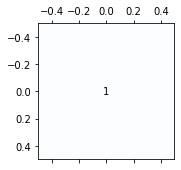

In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def show_confusion(y_real_s, y_pred_s):
    confmat = confusion_matrix(y_true=y_real_s, y_pred=y_pred_s)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')

    cm = {'tp': confmat[0, 0], 'fn': confmat[0, 1], 'fp': confmat[1, 0], 'tn': confmat[1, 1]}
    print(cm)
    total = sum(cm.values())
    print("accuracy:", (cm['tp']+cm['tn'])/total)

    recall = (cm['tp'])/(cm['tp']+cm['fn'])
    print("recall:", recall)

    precision = (cm['tp'])/(cm['tp']+cm['fp'])
    print("precision:", precision)

    print("f1-score:", 2/((1/precision)+(1/recall)))
    plt.xlabel('Prediction')        
    plt.ylabel('Real Label')
    plt.show()
    
show_confusion(y_real_s, y_pred_s)

In [ ]:
2/((1/0.972)+(1/1))

In [172]:
labels, texts = [], []
with open("1209\\中央社已處理\\test_answer.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()
        if not line:break
        labels.append(1 if '1' in line else 0)
        #labels.append([int(i) for i in line]+[0 for j in range(MAX_LEN - len(line))])
    
with open("1209\\中央社已處理\\test_input.txt",'r',encoding='utf-8') as text:    
    while True:
        line = text.readline().strip()
        if not line:break
        texts.append(line)
'''       
with open("1209\\testCorpus.txt",'r',encoding='utf-8') as test:
    while True:
        line = test.readline().strip()
        if not line:break
        texts.append(line)
        labels.append([0 for j in range(MAX_LEN)])
''' 
        
test_inputs, test_masks = preprocessing_for_bert(texts)
test_labels = torch.tensor(labels)
print(test_labels.size(), test_inputs.size())

test_data = TensorDataset(test_inputs, test_labels, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#cor_count, df, y_real_s, y_pred_s = get_test_result(test_dataloader)
get_test_result(test_dataloader)

#df.to_csv('test/Bert20WLSTMSIGHAN2014.csv'.format(epochs,mode))
#df

NameError: name 'preprocessing_for_bert_At' is not defined

In [33]:
'''
bert_classifier, optimizer, scheduler = initialize_model(epochs)
checkpoint = torch.load('ckpt/bert_weight_10.h5')
bert_classifier.load_state_dict(checkpoint)
bert_classifier.eval()
'''

cor_count, df, y_real_s, y_pred_s = get_test_result(test_dataloader)
show_confusion(y_real_s, y_pred_s)
print(cor_count)
df.to_csv('test/Bert{}EpochErr_{}_SIGHAN_40w_16.csv'.format(epochs,mode))
df

ValueError: not enough values to unpack (expected 3, got 2)